<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>

## **Школа глубокого обучения ФПМИ МФТИ**

## **Домашнее задание: Autoencoders, Variational Autoencoders**

## **Stepik: Павел Цветов, User ID: 39555013**


In [1]:
!nvidia-smi

Mon May 31 19:17:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [2]:
import numpy as np
import pandas as pd

import os
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable


import skimage.io
import skimage
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
from IPython.display import clear_output

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

%matplotlib inline

In [3]:
# def setup_seed(seed):
#   np.random.seed(seed)
#   torch.manual_seed(seed)
#   torch.cuda.manual_seed_all(seed)
#   torch.backends.cudnn.deterministic = True
#   torch.backends.cudnn.benchmark = False

# seed = 41

# setup_seed(seed)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [6]:
data, attrs = fetch_dataset()

In [7]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

In [8]:
data = np.array(data, dtype='float32') # convert images to float32 type

dataset = torch.from_numpy(data)
dataset = dataset.transpose(1, 3) # reshape tensor dataset to shape Batch x Channels x Height x Width

In [9]:
dataset.shape

torch.Size([13143, 3, 64, 64])

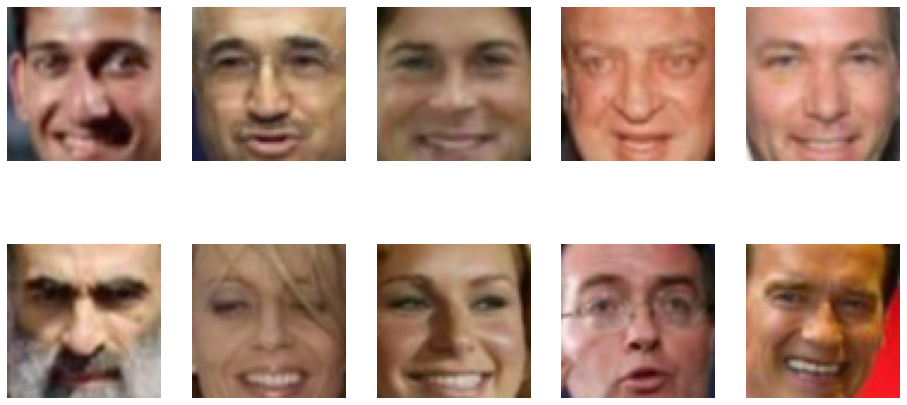

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(16,8))

for ax in axes.flat:
    i = int(np.random.uniform(0, len(data) - 1))
    ax.imshow(dataset[i].transpose(0, 2).numpy())
    ax.axis('off')


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [11]:
train_photos, test_photos = train_test_split(dataset, test_size=0.1)

train_dataloader = DataLoader(train_photos, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_photos, batch_size=128, shuffle=False)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [12]:
from torchsummary import summary

In [13]:
class ConvAutoencoder(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=5),
            nn.Flatten(),
            nn.Linear(18432, 4096),
            nn.ReLU(), 
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, hidden)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden, 2048),
            nn.ReLU(), 
            nn.Linear(2048, 4096),
            nn.ReLU(), 
            nn.Linear(4096, 18432), 
            nn.Unflatten(1, (128, 12, 12)), 
            nn.ConvTranspose2d(128, 32, 5),
            nn.ReLU(), 
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [14]:
class LinearAutoencoder(nn.Module):
    def __init__(self, input_size, hidden):
      super().__init__()
      self.encoder = nn.Sequential(
          nn.Linear(input_size, 512),
          nn.ReLU(),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Linear(64, hidden)
      )
        
      self.decoder = nn.Sequential(
          nn.Linear(hidden, 64),
          nn.ReLU(),
          nn.Linear(64, 128),
          nn.ReLU(),
          nn.Linear(128, 256),
          nn.ReLU(),
          nn.Linear(256, 512),
          nn.ReLU(),
          nn.Linear(512, input_size)
      )
    
    def forward(self, x):
      shapes = x.shape
      x = x.view(x.size(0), -1)
      return self.decoder(self.encoder(x)).view(*shapes)
    
    def encode(self, x):
      x = x.view(x.size(0), -1)
      return self.encoder(x)

    def decode(self, x):
      x = x.view(x.size(0), -1)
      return self.decoder(x)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [15]:
gc.collect()
torch.cuda.empty_cache()

### Linear Autoencoder

In [16]:
def train(model, optimizer, loss_fn, epochs, train_dataloader, test_dataloader, scheduler=None):
  
  x_test = next(iter(test_dataloader))
  train_history, test_history = [], []

  for epoch in tqdm(range(epochs)):

      model.train()
      train_loss = 0

      for x in train_dataloader:
          
          optimizer.zero_grad()

          x = x.to(device)
          x_pred = model(x)

          loss = loss_fn(x_pred, x)
          loss.backward()

          optimizer.step()
          
          if scheduler is not None:
            scheduler.step()

          train_loss += loss.item()

      train_loss /= len(train_dataloader)

      train_history.append(train_loss)

      model.eval()

      x = x_test.to(device)

      x_pred = model(x)
      loss = loss_fn(x_pred, x)

      test_loss = loss.item()

      test_history.append(test_loss)

      x = x.cpu().data
      x_pred = x_pred.cpu().data

      clear_output(wait=True)

      fig, axes = plt.subplots(2, 10, figsize=(16,8))
      fig.suptitle(f'{epoch+1} / {epochs} - train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}')

      for ax in axes.flat:
          ax.set_xticks([]); ax.set_yticks([])
      for i, ax in enumerate(axes[0]):
          ax.imshow(x[i].transpose(0, 2).numpy())
          ax.set_title('Real')
      for i, ax in enumerate(axes[1]):
          ax.imshow(x_pred[i].transpose(0, 2).numpy())
          ax.set_title('Generated')

      plt.show()

  return train_history, test_history

In [17]:
epochs = 50

In [18]:
loss_fn = nn.MSELoss()

model = LinearAutoencoder(3*64*64, 16)
model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [19]:
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       6,291,968
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 16]           1,040
           Linear-10                   [-1, 64]           1,088
             ReLU-11                   [-1, 64]               0
           Linear-12                  [-1, 128]           8,320
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


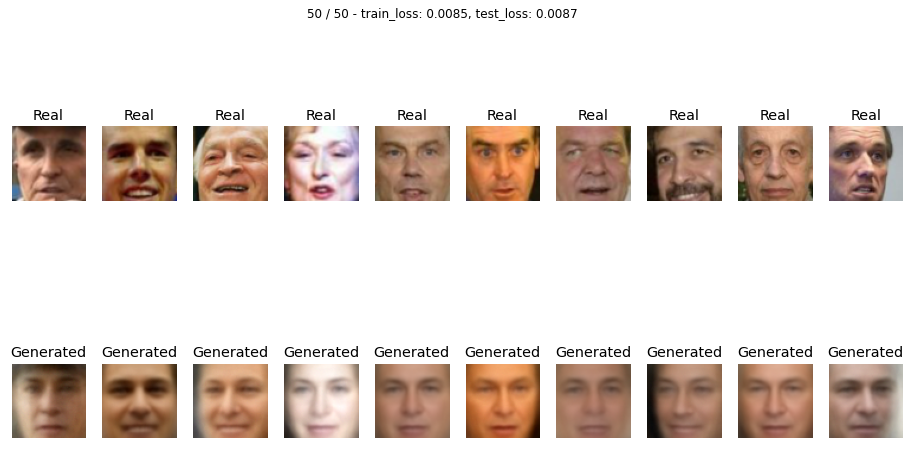

In [20]:
train_history, test_history = train(model, optimizer, loss_fn, epochs, train_dataloader, test_dataloader)

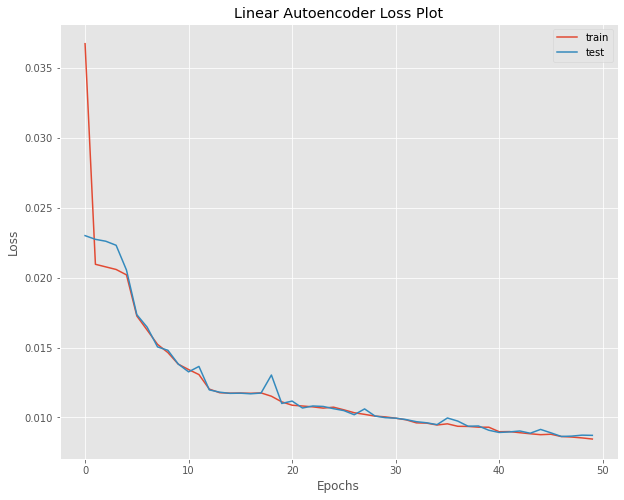

In [21]:
plt.figure(figsize=(10, 8))

plt.plot(range(epochs), train_history, label='train')
plt.plot(range(epochs), test_history, label='test')

plt.title('Linear Autoencoder Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

### Convolutional Autoencoder

In [22]:
gc.collect()
torch.cuda.empty_cache()

In [23]:
epochs = 20

In [24]:
model = ConvAutoencoder(16)
model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [25]:
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
              ReLU-4           [-1, 32, 16, 16]               0
            Conv2d-5          [-1, 128, 12, 12]         102,528
           Flatten-6                [-1, 18432]               0
            Linear-7                 [-1, 4096]      75,501,568
              ReLU-8                 [-1, 4096]               0
            Linear-9                 [-1, 2048]       8,390,656
             ReLU-10                 [-1, 2048]               0
           Linear-11                   [-1, 16]          32,784
           Linear-12                 [-1, 2048]          34,816
             ReLU-13                 [-1, 2048]               0
           Linear-14                 [-

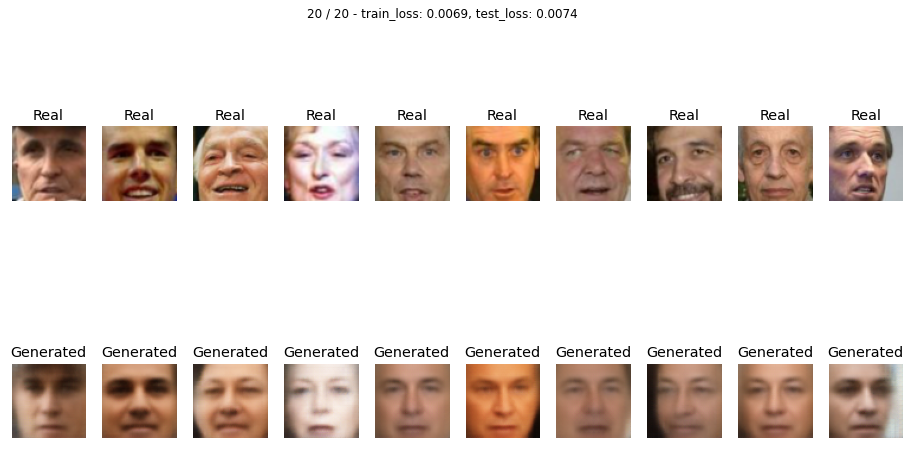

In [26]:
train_history, test_history = train(model, optimizer, loss_fn, epochs, train_dataloader, test_dataloader)

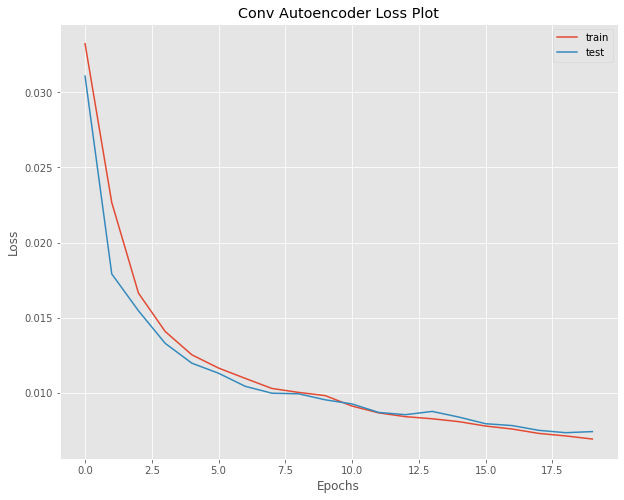

In [27]:
plt.figure(figsize=(10, 8))

plt.plot(range(epochs), train_history, label='train')
plt.plot(range(epochs), test_history, label='test')

plt.title('Conv Autoencoder Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

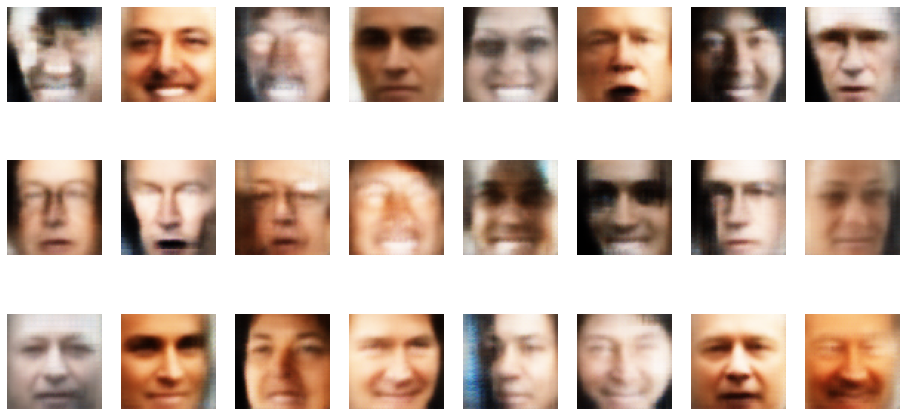

In [28]:
std_mu, std_sigma = 0, 1
z = std_mu + std_sigma * np.random.randn(24, 16)
z = torch.from_numpy(z.astype('float32')).to(device)
output = model.decode(z).detach().cpu().data

fig, axes = plt.subplots(3, 8, figsize=(16,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(output[i].transpose(0,2).numpy())
    ax.axis('off')

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [29]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

In [30]:
def get_top_faces_by_category(df: pd.DataFrame, attribute: str, n: int=20):
    
    filtered_df = df.sort_values(by=attribute, ascending=False)[attribute]
    return filtered_df[:n].index.tolist()

def show_faces_by_category(category: str, n: int=20):

    faces = get_top_faces_by_category(attrs, category, n=n)
    fig, axes = plt.subplots(1, 10, figsize=(16,8))
    
    for ax, im in zip(axes.flat, dataset[faces]):
        ax.imshow(im.transpose(0,2).numpy())
        ax.set_title(category)
        ax.axis('off')
    
    plt.show()

def transform_faces_by_category(source_category: str, target_category: str, n: int=15):

    source_faces = get_top_faces_by_category(attrs, source_category, n=n)
    target_faces = get_top_faces_by_category(attrs, target_category, n=n)

    source_encoded = model.encode(dataset[source_faces].to(device))
    target_encoded = model.encode(dataset[target_faces].to(device))

    diff_vector = target_encoded.mean(axis=0) - source_encoded.mean(axis=0)

    result = model.decode((source_encoded + diff_vector))
    result.to(device)
    result = result.detach().cpu().data
    
    source = dataset[source_faces]
    
    fig, axes = plt.subplots(2, 10, figsize=(16, 8))

    for ax in axes.flat: 
      for i, ax in enumerate(axes[0]):
        ax.imshow(source[i].transpose(0,2).numpy())
        ax.axis('off')
        ax.set_title('Original')
      for i, ax in enumerate(axes[1]):
        ax.imshow(result[i].transpose(0,2).numpy())
        ax.axis('off')
        ax.set_title('Transformed')

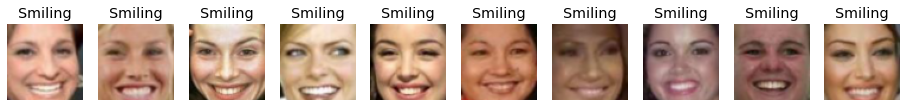

In [31]:
show_faces_by_category('Smiling')

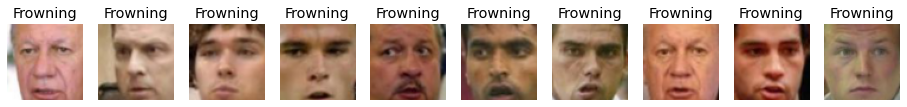

In [32]:
show_faces_by_category('Frowning')

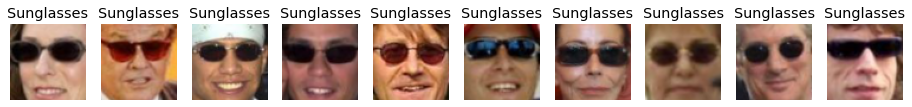

In [33]:
show_faces_by_category('Sunglasses')

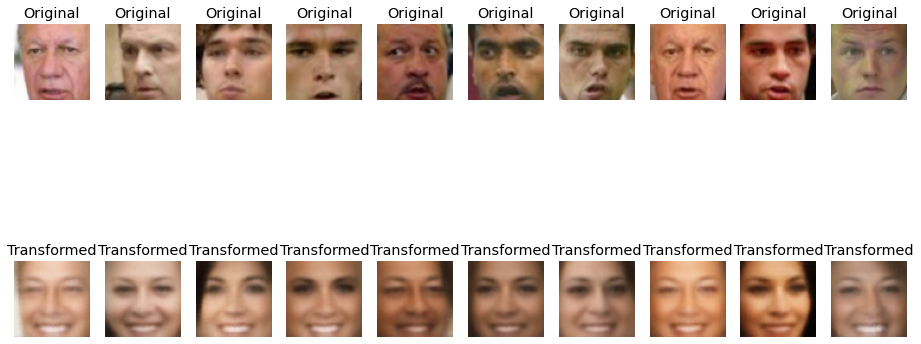

In [34]:
transform_faces_by_category('Frowning', 'Smiling', n=30)

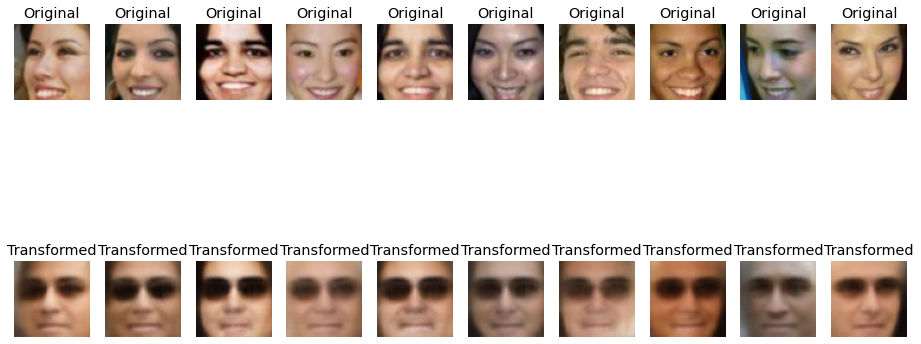

In [35]:
transform_faces_by_category('Youth', 'Sunglasses', n=30)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [36]:
batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [37]:
def OneHotEncoder(idx, n):
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    return onehot

class Encoder(nn.Module):
    
    def __init__(self, conditional):
        
        super().__init__()
        self.conditional = conditional
        s0 = 28*28+10 if conditional else 28*28

        self.encoder = nn.Sequential(
            nn.Linear(s0, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(), 
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        self.linear_means = nn.Linear(128, 16)
        self.linear_log_var = nn.Linear(128, 16)

    def forward(self, x, c):
        if self.conditional:
            c = OneHotEncoder(c, n=10)
            x = torch.cat((x, c), dim=-1)
        x = self.encoder(x)
        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)
        return means, log_vars

class Decoder(nn.Module):

    def __init__(self, conditional):
        
        super().__init__()
        self.conditional = conditional
        s0 = 16+10 if conditional else 16

        self.decoder = nn.Sequential(
            nn.Linear(s0, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(), 
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(), 
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, z, c):
        if self.conditional:
            c = OneHotEncoder(c, n=10)
            z = torch.cat((z, c), dim=-1)
        x = self.decoder(z)
        return x

class LinearVAE(nn.Module):
    
    def __init__(self, conditional=False):
        
        super().__init__()
        
        self.encoder = Encoder(conditional)
        self.decoder = Decoder(conditional)
    
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def encode(self, x, c=None):
        x = x.view(-1, 28*28)
        means, log_var = self.encoder(x, c)
        z = self.reparameterize(means, log_var)
        return means, log_var, z

    def decode(self, z, c=None):
        recon_x = self.decoder(z, c)
        recon_x = recon_x.view(-1, 1, 28, 28)
        return recon_x

    def forward(self, x, c=None):
        means, log_var, z = self.encode(x, c)
        recon_x = self.decode(z, c)
        return recon_x, means, log_var, z

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [38]:
def loss_vae(reconstructed, x, mu, log_var):

    BCE = torch.nn.functional.binary_cross_entropy(reconstructed.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    KL = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + KL

И обучим модель:

In [39]:
gc.collect()
torch.cuda.empty_cache()

In [40]:
loss_fn = loss_vae

model = LinearVAE()
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [41]:
epochs = 50

In [42]:
summary(model, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
       BatchNorm1d-2                  [-1, 512]           1,024
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
       BatchNorm1d-5                  [-1, 256]             512
              ReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
       BatchNorm1d-8                  [-1, 128]             256
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 16]           2,064
           Linear-11                   [-1, 16]           2,064
          Encoder-12       [[-1, 16], [-1, 16]]               0
           Linear-13                  [-1, 256]           4,352
      BatchNorm1d-14                  [

In [43]:
def train_vae(model, optimizer, loss_fn, epochs, train_dataloader, test_dataloader, scheduler=None):
  
  x_test, y_test = next(iter(test_dataloader))
  train_history, test_history = [], []
  
  for epoch in tqdm(range(epochs)):

      model.train()
      train_loss = 0

      for x, y in train_dataloader:
          
          optimizer.zero_grad()

          x = x.to(device)
          y = y.to(device)

          reconstructed, mean, log_var, z = model(x, y)

          loss = loss_fn(reconstructed, x, mean, log_var)
          loss.backward()

          optimizer.step()
          
          if scheduler is not None:
            scheduler.step()

          train_loss += loss.item()

      train_loss /= len(train_dataloader)

      train_history.append(train_loss)

      model.eval()

      x, y = x_test, y_test
      
      x = x.to(device)
      y = y.to(device)

      reconstructed, mean, log_var, z = model(x, y)
      loss = loss_fn(reconstructed, x, mean, log_var)
      test_loss = loss.item()

      test_history.append(test_loss)

      x = x.cpu().detach().data
      reconstructed = reconstructed.cpu().detach().data

      clear_output(wait=True)

      fig, axes = plt.subplots(2, 10, figsize=(16,8))
      fig.suptitle(f'{epoch+1} / {epochs} - train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}')

      for ax in axes.flat:
          ax.set_xticks([]); ax.set_yticks([])
          
      for i, ax in enumerate(axes[0]):
          ax.imshow(x[i].reshape((28,28)), cmap='gray')
          ax.set_title('Real')
      for i, ax in enumerate(axes[1]):
          ax.imshow(reconstructed[i].reshape((28,28)), cmap='gray')
          ax.set_title('VAE')

      plt.show()

  return train_history, test_history

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

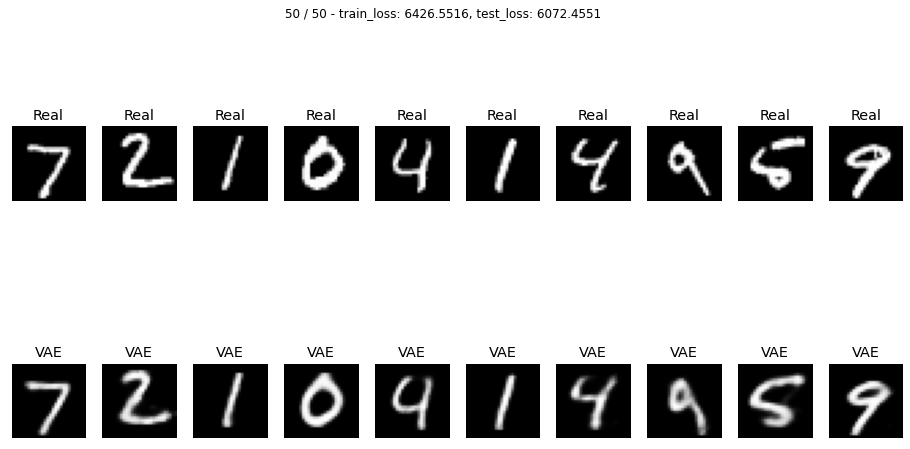

In [44]:
train_history, test_history = train_vae(model, optimizer, loss_fn, epochs, train_dataloader, test_dataloader)

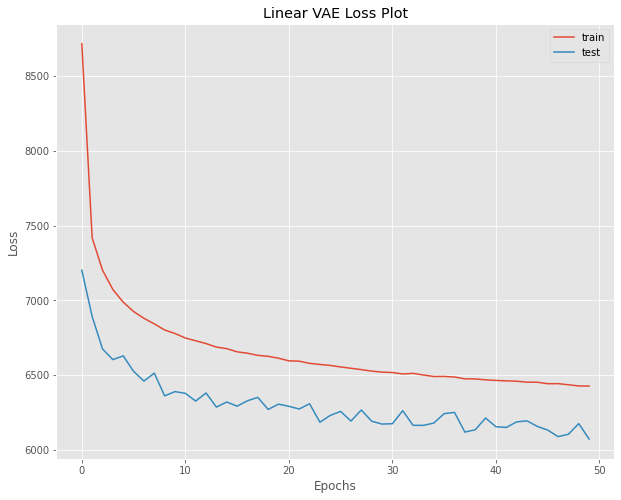

In [45]:
plt.figure(figsize=(10, 8))

plt.plot(range(epochs), train_history, label='train')
plt.plot(range(epochs), test_history, label='test')

plt.title('Linear VAE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

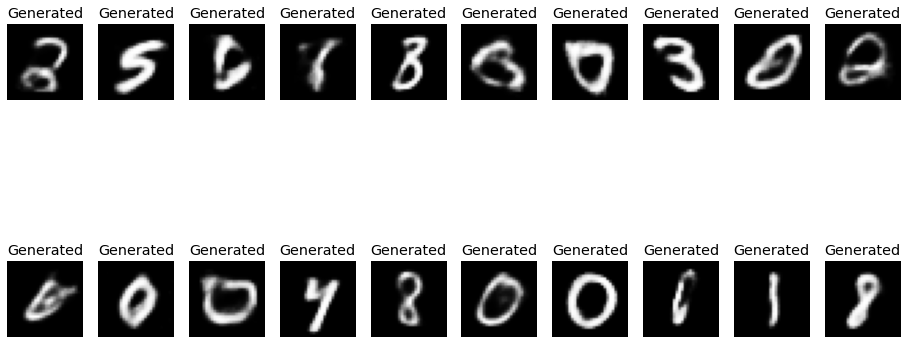

In [46]:
std_mu, std_sigma = 0, 1
z = std_mu + std_sigma * np.random.randn(24, 16)
z = torch.from_numpy(z.astype('float32')).to(device)
output = model.decode(z).detach().cpu().data

fig, axes = plt.subplots(2, 10, figsize=(16,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(output[i].reshape((28,28)), cmap='gray')
    ax.set_title('Generated')
    ax.axis('off')

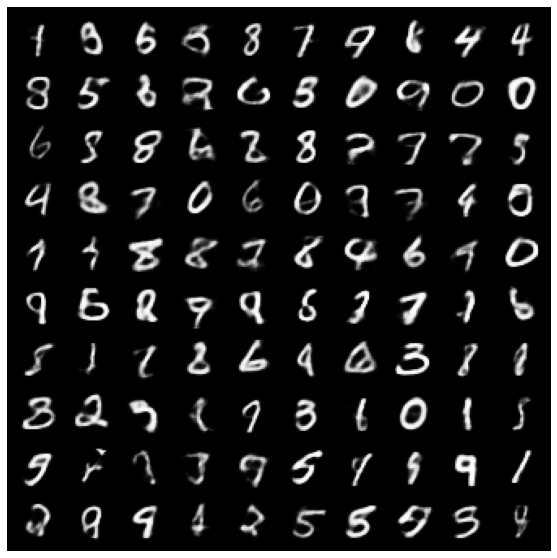

In [47]:
import torchvision

model.eval()

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, 16, device=device)

    # reconstruct images from the latent vectors
    image_reconstructed = model.decode(latent)
    image_reconstructed = image_reconstructed.cpu().detach().data

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis('off')
    show_image(torchvision.utils.make_grid(image_reconstructed.data[:100], 10, 5))
    plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

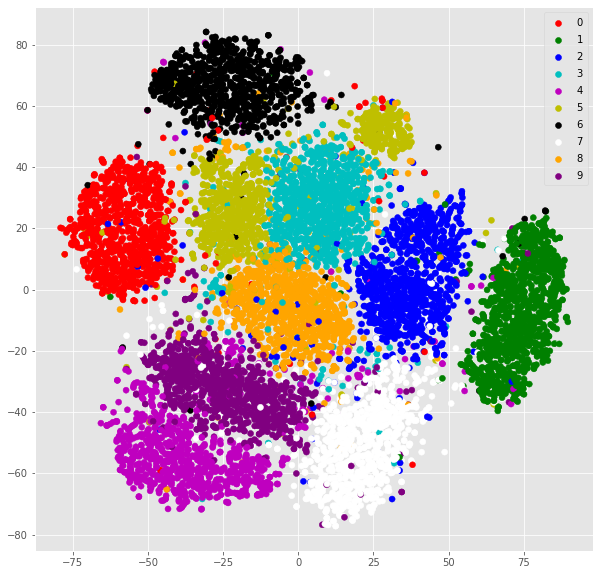

CPU times: user 1min 28s, sys: 315 ms, total: 1min 29s
Wall time: 1min 28s


In [48]:
%%time

from sklearn.manifold import TSNE

z = []

loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

for x, y in loader:
    x, y = x.to(device), y.to(device)
    z.append(model.encode(x, y)[2])

z = torch.cat(z).detach().cpu().data

tsne = TSNE(n_components=2, random_state=42)
coords = tsne.fit_transform(z)
labels = test_dataset.targets.tolist()

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']

plt.figure(figsize=(10,10))
scatter = plt.scatter(coords[:,0], coords[:,1], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.legend(*scatter.legend_elements())
plt.show()

Сразу же становятся видны разделимые кластеры чисел от 0 до 9 

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [49]:
gc.collect()
torch.cuda.empty_cache()

In [50]:
loss_fn = loss_vae

model = LinearVAE(conditional=True)
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [51]:
epochs=50

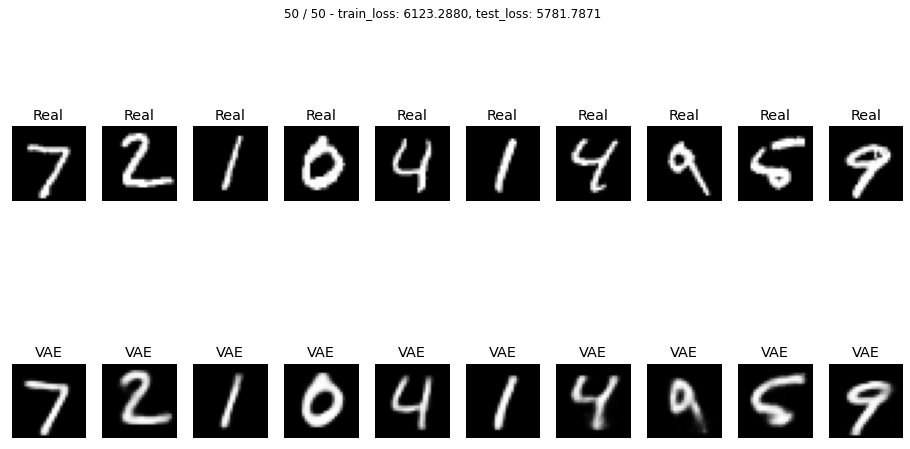

In [52]:
train_history, test_history = train_vae(model, optimizer, loss_fn, epochs, train_dataloader, test_dataloader)

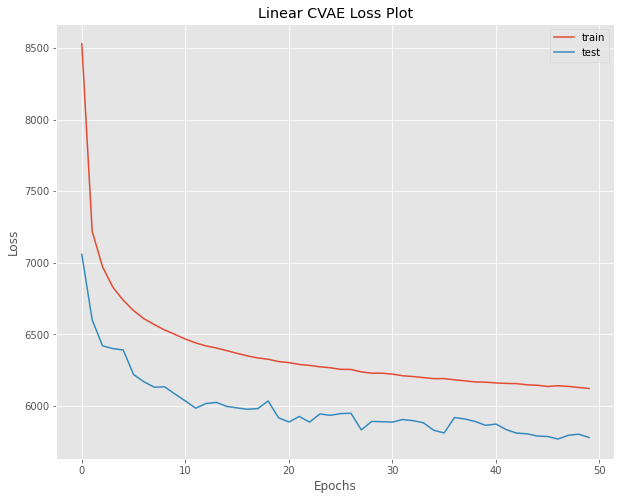

In [53]:
plt.figure(figsize=(10, 8))

plt.plot(range(epochs), train_history, label='train')
plt.plot(range(epochs), test_history, label='test')

plt.title('Linear CVAE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

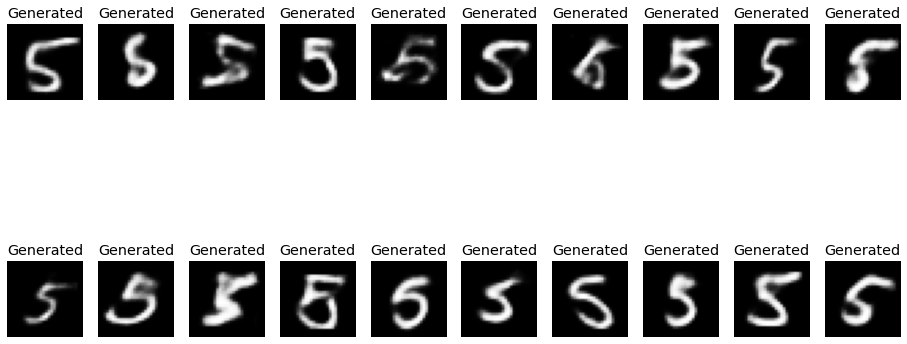

In [54]:
std_mu, std_sigma = 0, 1
z = std_mu + std_sigma * np.random.randn(20, 16)
z = torch.from_numpy(z.astype('float32')).to(device)
condition = torch.ones((), dtype=torch.int64).new_full((20,), 5).to(device)

output = model.decode(z, condition).detach().cpu().data


fig, axes = plt.subplots(2, 10, figsize=(16,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(output[i].reshape((28,28)), cmap='gray')
    ax.set_title('Generated')
    ax.axis('off')

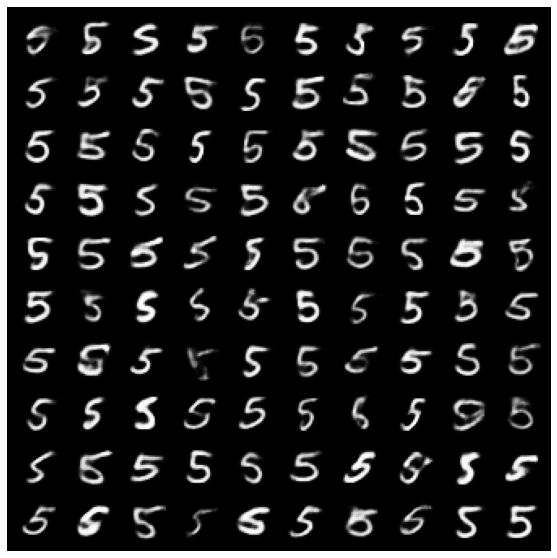

In [55]:
import torchvision

model.eval()

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, 16, device=device)

    # reconstruct images from the latent vectors
    condition = torch.ones((), dtype=torch.int64).new_full((128,), 5).to(device)
    image_reconstructed = model.decode(latent, condition)
    image_reconstructed = image_reconstructed.cpu().detach().data

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis('off')
    show_image(torchvision.utils.make_grid(image_reconstructed.data[:100], 10, 5))
    plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

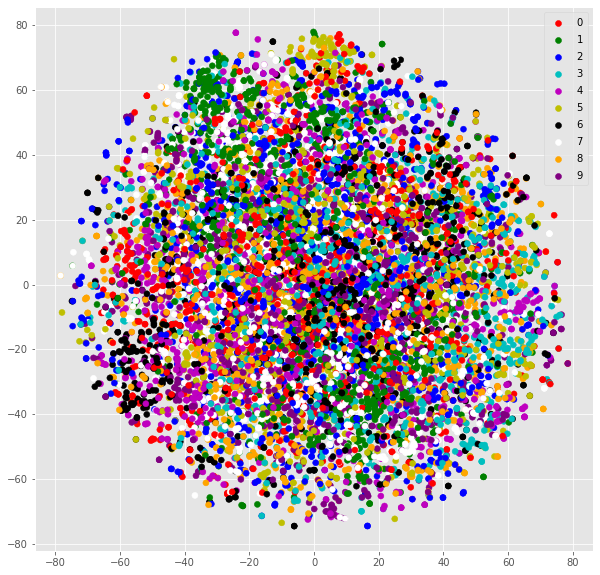

CPU times: user 1min 30s, sys: 261 ms, total: 1min 30s
Wall time: 1min 30s


In [56]:
%%time

from sklearn.manifold import TSNE

z = []

loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

for x, y in loader:
    x, y = x.to(device), y.to(device)
    z.append(model.encode(x, y)[2])

z = torch.cat(z).detach().cpu().data

tsne = TSNE(n_components=2, random_state=42)
coords = tsne.fit_transform(z)
labels = test_dataset.targets.tolist()

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']

plt.figure(figsize=(10,10))
scatter = plt.scatter(coords[:,0], coords[:,1], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.legend(*scatter.legend_elements())
plt.show()